   # Validation of static linear solver
   
Studies consider a flat/cambered aerofoil models. 
   
The linearisation of the model is performed as follows:
   - A geometrically-exact static solution is obtained for an arbitrary geometry/flow condition;
   - A linearisation is performed about this configuration;
   - incremental displacements/velocities are enforced on the linear models;
All linear solutions are compared to geometrically-exact one.
   

   #### Important:
   This version of the linear solver is based on a linearisation of the state equations only. Being $\Gamma_0$ the circulation at the reference (linearisation) point, the incremental circulation, $\Delta\Gamma$, is obtained. The total circulation, $\Gamma=\Gamma_0+\Delta\Gamma$ is finally used to obtain the induced velocity field. 
The total velocity field, $V$, is obtained upon summation with the free stream velocity, $U_\infty$ and gust disturbances/aerofoil motion ($\nu,\zeta'$) and used to compute the the steady forces through Joukovski theorem.

In summary, the state-space formulation used is:
$$
\dot{x}=A x + B u \\
y = g(x+\Delta x,u + \Delta u)
$$
where $x$ and $u$ are system state and input.

In [33]:
import os,sys
sys.path.append('..')
import copy

import numpy  as np
import scipy.optimize as scopt
import matplotlib.pyplot as plt

import uvlm2d_sta as uvlm
import lin_uvlm2d_sta as linuvlm

import geo
import pp_uvlm2d as pp

## Flat plate: exact vs. linearisation around 0 deg

In this test a model of a flat plate at zero angle of attack is created and linearised. A rotation is imposed on the linear model and the force coefficients are computed. The results are compared against the nonlinear solution for different paneling/angles of attack.

   #### Note: 
   In order to rotate the aerofoil, a set of nodal displacements $\Delta\zeta$ is applied. Importantly, the rotation is exact, i.e. both horizontal and vertical displacements are considered.

Testing steady aerofoil for M=1...
	alpha==0.10 deg
	alpha==0.50 deg
	alpha==1.00 deg
	alpha==2.00 deg
	alpha==4.00 deg
	alpha==6.00 deg
	alpha==8.00 deg
	alpha==10.00 deg
	alpha==12.00 deg
	alpha==14.00 deg
Testing steady aerofoil for M=8...
	alpha==0.10 deg
	alpha==0.50 deg
	alpha==1.00 deg
	alpha==2.00 deg
	alpha==4.00 deg
	alpha==6.00 deg
	alpha==8.00 deg
	alpha==10.00 deg
	alpha==12.00 deg
	alpha==14.00 deg
Testing steady aerofoil for M=16...
	alpha==0.10 deg
	alpha==0.50 deg
	alpha==1.00 deg
	alpha==2.00 deg
	alpha==4.00 deg
	alpha==6.00 deg
	alpha==8.00 deg
	alpha==10.00 deg
	alpha==12.00 deg
	alpha==14.00 deg


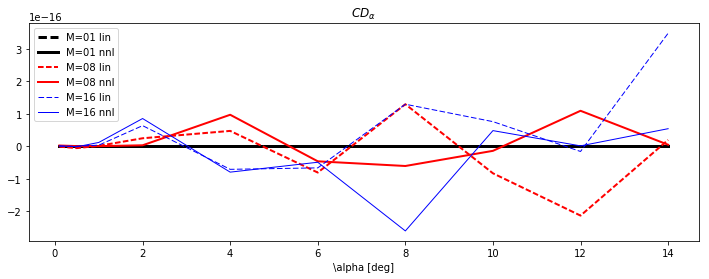

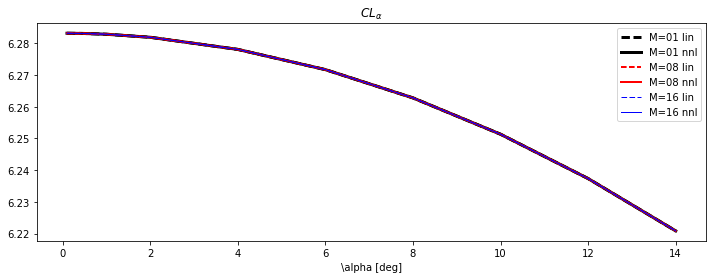

In [11]:
MList=[1,8,16]
DAlphaList=[0.1,0.5,1.,2.,4.,6.,8.,10.,12.,14.] # degs

Nm=len(MList)
Na=len(DAlphaList)

CDlin,CLlin=np.zeros((Na,Nm)),np.zeros((Na,Nm))
CDnnl,CLnnl=np.zeros((Na,Nm)),np.zeros((Na,Nm))

for mm in range(len(MList)):

    # input: reference condition: flat plate at zero angle
    Mw=2
    M=MList[mm]
    alpha=0.*np.pi/180.
    chord=3.
    b=0.5*chord
    Uinf=np.array([20.,0.])
    rho=1.225
    S0=uvlm.solver(M,Mw,b,Uinf,alpha,rho=1.225)
    S0.build_flat_plate()
    S0.solve_static_Gamma2d()

    print('Testing steady aerofoil for M=%d...' %M)

    for aa in range(len(DAlphaList)):

        # Perturbation
        dalpha=np.pi/180.*DAlphaList[aa] # angle [rad]
        dUinf=0.0 # velocity [m/s]
        qinf_tot=0.5*rho*(S0.Uabs+dUinf)**2
        print('\talpha==%.2f deg' %DAlphaList[aa])


        ### Linearised solution 

        # Perturb reference state
        ZetaRot=geo.rotate_aerofoil(S0.Zeta,dalpha)
        dZeta=ZetaRot-S0.Zeta
        Slin=linuvlm.solver(S0)
        Slin.Zeta=dZeta
        # solve
        Slin.solve_static_Gamma2d()
        # store data
        CDlin[aa,mm],CLlin[aa,mm]=np.sum(Slin.FmatSta,0)/\
                                 (qinf_tot*Slin.S0.chord*(alpha+dalpha))

        ### Reference nonlinear solution
        Sref=uvlm.solver(M,Mw,b,Uinf,alpha+dalpha,rho)
        Sref.build_flat_plate()
        # solve
        Sref.solve_static_Gamma2d()
        # store
        CDnnl[aa,mm],CLnnl[aa,mm]=np.sum(Sref.FmatSta,0)/\
                                    (qinf_tot*Sref.chord*(alpha+dalpha))

clist=['k','r','b','0.6',]
fig1 = plt.figure('Drag coefficient',(12,4))
ax1=fig1.add_subplot(111)
fig2 = plt.figure('Lift coefficient',(12,4))
ax2=fig2.add_subplot(111)

for mm in range(Nm):
    #
    ax1.plot(DAlphaList,CDlin[:,mm],clist[mm],lw=Nm-mm,ls='--',
                                          label=r'M=%.2d lin'%MList[mm])
    ax1.plot(DAlphaList,CDnnl[:,mm],clist[mm],lw=Nm-mm,
                                          label=r'M=%.2d nnl'%MList[mm])
    #
    ax2.plot(DAlphaList,CLlin[:,mm],clist[mm],lw=Nm-mm,ls='--',
                                          label=r'M=%.2d lin'%MList[mm])
    ax2.plot(DAlphaList,CLnnl[:,mm],clist[mm],lw=Nm-mm,
                                          label=r'M=%.2d nnl'%MList[mm])

ax1.set_xlabel(r'\alpha [deg]')
ax1.set_title(r'$CD_\alpha$')
ax1.legend()
ax2.set_xlabel(r'\alpha [deg]')
ax2.set_title(r'$CL_\alpha$')
ax2.legend()
plt.show()

The difference in $CL_\alpha$ prediction between the linearised and geometrically-exact  model is shown below:

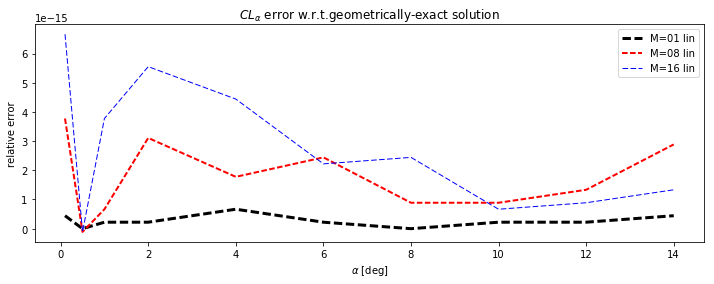

In [15]:
fig1 = plt.figure('Relative error lift coefficient',(12,4))
ax1=fig1.add_subplot(111)
for mm in range(Nm):
    ax1.plot(DAlphaList,CLlin[:,mm]/CLnnl[:,mm]-1.,clist[mm],lw=Nm-mm,ls='--',
                                          label=r'M=%.2d lin'%MList[mm])
ax1.set_xlabel(r'$\alpha$ [deg]')
ax1.set_ylabel(r'relative error')
ax1.set_title(r'$CL_\alpha$ error w.r.t.geometrically-exact solution')
ax1.legend()
ax2.legend()
plt.show()

- The nonlinear solution is consistent across parametrisation, with the $CL_\alpha \to 2\pi$ as $\alpha \to 0$; as $\alpha$ increases, the $CL_\alpha$ drops, as a consequence of the exact rotation. The drag is always null, as expected.
- The linearised solution is always consistent with the geometrically-exact one, also predicting the $CL_\alpha$ drop with the angle of attack.

## Cambered plate: exact vs. linearised

In this test a model of a camber plate is considered. Two linearisations of this model, about 0 deg and 10 deg are considered. The aerodynamic forced computed through these two models are compared to those predicted by the geometrically-exact solution over a range of angles of attack.

As before, rotation is imposed on the linear model enforcing both $x$ and $y$ displacements.

Testing steady aerofoil for M=20...
	alpha==0.00 deg
	alpha==0.10 deg


/home/sm6110/anaconda3-4.3.0/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/home/sm6110/anaconda3-4.3.0/lib/python3.6/site-packages/ipykernel/__main__.py:76: RuntimeWarning: divide by zero encountered in true_divide
/home/sm6110/anaconda3-4.3.0/lib/python3.6/site-packages/ipykernel/__main__.py:86: RuntimeWarning: divide by zero encountered in true_divide


	alpha==0.20 deg
	alpha==0.30 deg
	alpha==0.50 deg
	alpha==1.00 deg
	alpha==2.00 deg
	alpha==4.00 deg
	alpha==6.00 deg
	alpha==8.00 deg
	alpha==9.50 deg
	alpha==9.70 deg
	alpha==9.80 deg
	alpha==9.90 deg
	alpha==10.00 deg
	alpha==10.10 deg
	alpha==10.20 deg
	alpha==10.30 deg
	alpha==10.50 deg
	alpha==12.00 deg
	alpha==14.00 deg
	alpha==16.00 deg
	alpha==18.00 deg


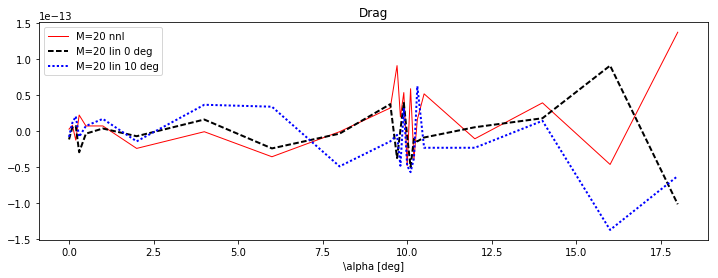

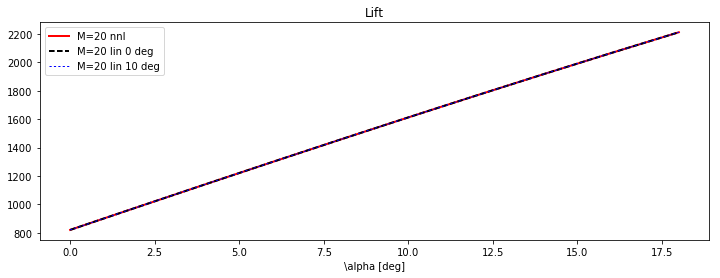

In [28]:
DAlphaList=[0.0,0.1,0.2,0.3,0.5,1.,2.,4.,6.,8.,
            9.5,9.7,9.8,9.9,10.,10.1,10.2,10.3,10.5,12.,14.,16.,18.] # degs

MList=[20]
Nm,mm=1,0
Na=len(DAlphaList)

CDlin01,CLlin01=np.zeros((Na,Nm)),np.zeros((Na,Nm))
CDlin02,CLlin02=np.zeros((Na,Nm)),np.zeros((Na,Nm))
CDnnl,CLnnl=np.zeros((Na,Nm)),np.zeros((Na,Nm))

Llin01,Dlin01=np.zeros((Na,Nm)),np.zeros((Na,Nm))
Llin02,Dlin02=np.zeros((Na,Nm)),np.zeros((Na,Nm))
Lnnl,Dnnl=np.zeros((Na,Nm)),np.zeros((Na,Nm))

# input:
Mw=2
M=20
chord=3.
b=0.5*chord
Uinf=np.array([20.,0.])
rho=1.225

# reference condition 1: aerofoil at 0 deg angle
alpha01=0.*np.pi/180.
S01=uvlm.solver(M,Mw,b,Uinf,alpha01,rho=1.225)
S01.build_camber_plate(Mcamb=10,Pcamb=4)
S01.solve_static_Gamma2d()
Ftot0=np.sum(S01.FmatSta,0)

# reference condition 2: aerofoil at 10 deg angle
alpha02=10.*np.pi/180.
S02=uvlm.solver(M,Mw,b,Uinf,alpha02,rho=1.225)
S02.build_camber_plate(Mcamb=10,Pcamb=4)
S02.solve_static_Gamma2d()


print('Testing steady aerofoil for M=%d...' %M)

for aa in range(len(DAlphaList)):

    # Perturbation
    alpha_tot=np.pi/180.*DAlphaList[aa]
    dUinf=0.0 # velocity [m/s]
    qinf_tot=0.5*rho*(S01.Uabs+dUinf)**2
    print('\talpha==%.2f deg' %DAlphaList[aa])


    ### Linearised solution 01:
    # Perturb reference state
    dalpha01=alpha_tot-alpha01 # angle [rad]
    ZetaRot=geo.rotate_aerofoil(S01.Zeta,dalpha01)
    dZeta=ZetaRot-S01.Zeta
    Slin01=linuvlm.solver(S01)
    Slin01.Zeta=dZeta
    # solve
    Slin01.solve_static_Gamma2d()
    # store data
    Dlin01[aa,mm],Llin01[aa,mm]=np.sum(Slin01.FmatSta,0)
    dFtot01=np.sum(Slin01.FmatSta,0)-Ftot0
    CDlin01[aa,mm],CLlin01[aa,mm]=dFtot01/\
                                (qinf_tot*Slin01.S0.chord*alpha_tot)


    ### Linearised solution 02:
    # Perturb reference state
    dalpha02=alpha_tot-alpha02 # angle [rad]
    ZetaRot=geo.rotate_aerofoil(S02.Zeta,dalpha02)
    dZeta=ZetaRot-S02.Zeta
    Slin02=linuvlm.solver(S02)
    Slin02.Zeta=dZeta
    # solve
    Slin02.solve_static_Gamma2d()
    # store data
    Dlin02[aa,mm],Llin02[aa,mm]=np.sum(Slin02.FmatSta,0)
    dFtot02=np.sum(Slin02.FmatSta,0)-Ftot0
    CDlin02[aa,mm],CLlin02[aa,mm]=dFtot02/\
                                (qinf_tot*Slin02.S0.chord*alpha_tot)


    ### Reference nonlinear solution
    Sref=uvlm.solver(M,Mw,b,Uinf,alpha_tot,rho)
    Sref.build_camber_plate(Mcamb=10,Pcamb=4)
    # solve
    Sref.solve_static_Gamma2d()
    # store
    Dnnl[aa,mm],Lnnl[aa,mm]=np.sum(Sref.FmatSta,0)
    CDnnl[aa,mm],CLnnl[aa,mm]=np.sum(Sref.FmatSta,0)/\
                                     (qinf_tot*Sref.chord*alpha_tot)

clist=['k','r','b','0.6',]

### Aerodynamic forces
fig1 = plt.figure('Drag',(12,4))
fig2 = plt.figure('Lift',(12,4))
ax1=fig1.add_subplot(111)
ax2=fig2.add_subplot(111)

ax1.plot(DAlphaList,Dnnl[:,mm],'r',lw=Nm-mm,
                                      label=r'M=%.2d nnl'%MList[mm])
ax1.plot(DAlphaList,Dlin01[:,mm],'k',lw=2,ls='--',
                                label=r'M=%.2d lin 0 deg'%MList[mm])
ax1.plot(DAlphaList,Dlin02[:,mm],'b',lw=2,ls=':',
                               label=r'M=%.2d lin 10 deg'%MList[mm])

#
ax2.plot(DAlphaList,Lnnl[:,mm],'r',lw=2,
                                      label=r'M=%.2d nnl'%MList[mm])
ax2.plot(DAlphaList,Llin01[:,mm],'k',lw=2,ls='--',
                                label=r'M=%.2d lin 0 deg'%MList[mm])
ax2.plot(DAlphaList,Llin02[:,mm],'b',lw=Nm-mm,ls=':',
                               label=r'M=%.2d lin 10 deg'%MList[mm])


ax1.set_xlabel(r'\alpha [deg]')
ax1.set_title(r'Drag')
ax1.legend()
ax2.set_xlabel(r'\alpha [deg]')
ax2.set_title(r'Lift')
ax2.legend()
plt.show()

As expected, the drag and lift predicted match perfectly across models. A plot of the relative error in computing the $CL_\alpha$ is shown below:

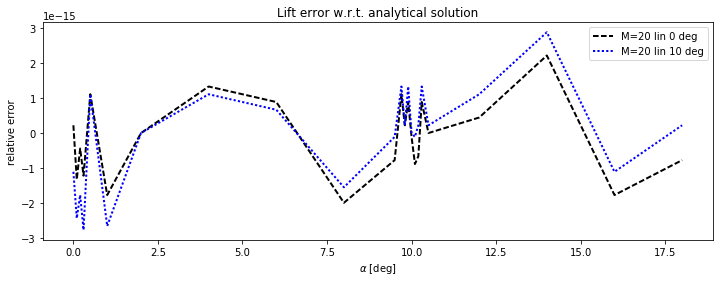

In [30]:
fig1 = plt.figure('Relative error lift',(12,4))
ax1=fig1.add_subplot(111)
ax1.plot(DAlphaList,Llin01[:,mm]/Lnnl[:,mm]-1.,'k',lw=2,ls='--',
                                      label=r'M=%.2d lin 0 deg'%MList[mm])
ax1.plot(DAlphaList,Llin02[:,mm]/Lnnl[:,mm]-1.,'b',lw=2,ls=':',
                                     label=r'M=%.2d lin 10 deg'%MList[mm])
ax1.set_xlabel(r'$\alpha$ [deg]')
ax1.set_ylabel(r'relative error')
ax1.set_title(r'Lift error w.r.t. analytical solution')
ax1.legend()
ax2.legend()
plt.show()

A plot of the aerofoil at 0 and 10 deg is shown below:

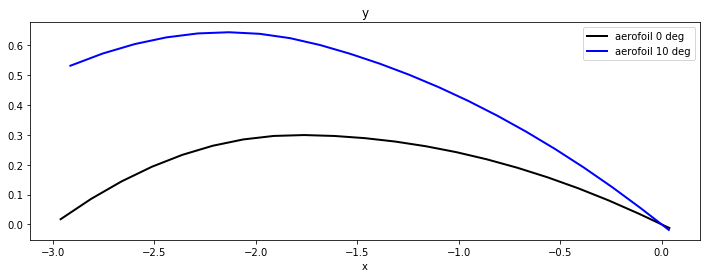

In [8]:
fig1 = plt.figure('Aerofoil',(12,4))
ax1=fig1.add_subplot(111)
ax1.plot(S01.Zeta[:,0],S01.Zeta[:,1],'k',lw=2,
                                label=r'aerofoil 0 deg')
ax1.plot(S02.Zeta[:,0],S02.Zeta[:,1],'b',lw=2,
                               label=r'aerofoil 10 deg')
ax1.set_xlabel(r'x')
ax1.set_title(r'y')
ax1.legend()
plt.show()

## Cambered aerofoil - gust speed increment

A cambered aerofoil is rotated of an angle $\alpha_0$ with respect to the horizontal line. The incoming flow speed is also rotated of an angle $\alpha_\infty$ so as to produce an effective angles of attack, $\alpha_e=\alpha_\infty-\alpha_0$. Vertical and horizontal forces are computed for a range of effective angles of attack. 

Tho linearisations of this model are produced. While in both cases the aerofoil has a geometrical angle $\alpha_0$, two different profiles of the incoming flow are chosen so as to produce effective angles of 0 and 10 deg. An incremental gust profile is finally added to the linearised models to reproduce a range of effective angles of attack.

Testing steady aerofoil for M=20...
	Alpha effective=0.00 deg
	Alpha effective=0.10 deg
	Alpha effective=0.20 deg
	Alpha effective=0.30 deg
	Alpha effective=0.50 deg
	Alpha effective=1.00 deg
	Alpha effective=2.00 deg
	Alpha effective=4.00 deg
	Alpha effective=6.00 deg
	Alpha effective=8.00 deg
	Alpha effective=9.50 deg
	Alpha effective=9.70 deg
	Alpha effective=9.80 deg
	Alpha effective=9.90 deg
	Alpha effective=10.00 deg
	Alpha effective=10.10 deg
	Alpha effective=10.20 deg
	Alpha effective=10.30 deg
	Alpha effective=10.50 deg
	Alpha effective=12.00 deg
	Alpha effective=14.00 deg
	Alpha effective=16.00 deg
	Alpha effective=18.00 deg


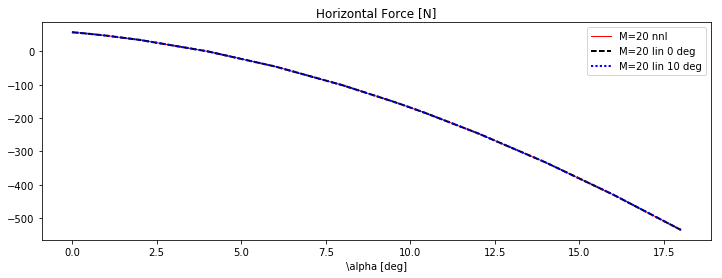

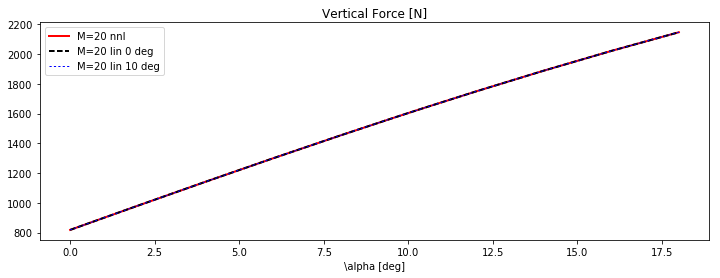

In [36]:
DAlphaList=[0.0,0.1,0.2,0.3,0.5,
            1.,2.,4.,6.,8.,
            9.5,9.7,9.8,9.9,10.,10.1,10.2,10.3,10.5,
            12.,14.,16.,18.] # degs

MList=[20]
Nm,mm=1,0
Na=len(DAlphaList)

CFXlin01,CFZlin01=np.zeros((Na,Nm)),np.zeros((Na,Nm))
CFXlin02,CFZlin02=np.zeros((Na,Nm)),np.zeros((Na,Nm))
CFXnnl,CFZnnl=np.zeros((Na,Nm)),np.zeros((Na,Nm))

FZlin01,FXlin01=np.zeros((Na,Nm)),np.zeros((Na,Nm))
FZlin02,FXlin02=np.zeros((Na,Nm)),np.zeros((Na,Nm))
FZnnl,FXnnl=np.zeros((Na,Nm)),np.zeros((Na,Nm))

# Reference input:
Mw=2
M=MList[mm]
chord=3.
b=0.5*chord
Uinf0=np.array([20.,0.])
rho=1.225
alpha0=4.0*np.pi/180. # angle of reference aerofoil w.r.t. horizontal line

# reference condition 1/2: aerofoil at 0 deg angle
S01=uvlm.solver(M,Mw,b,Uinf0,alpha0,rho=1.225)
S01.build_camber_plate(Mcamb=10,Pcamb=4)
S02=copy.deepcopy(S01)

alpha_eff01=0.*np.pi/180.
alpha_inf=alpha_eff01-alpha0
Uinf_here=geo.rotate_speed(Uinf0,alpha_inf)
S01.dZetadt[:,:]=-(Uinf_here-Uinf0)
S01.solve_static_Gamma2d()

alpha_eff02=10.*np.pi/180.
alpha_inf=alpha_eff02-alpha0
Uinf_here=geo.rotate_speed(Uinf0,alpha_inf)
S02.dZetadt[:,:]=-(Uinf_here-Uinf0)
S02.solve_static_Gamma2d()


print('Testing steady aerofoil for M=%d...' %M)

for aa in range(len(DAlphaList)):

    # Perturbation
    alpha_eff=np.pi/180.*DAlphaList[aa]
    alpha_inf=alpha_eff-alpha0
    Uinf_here=geo.rotate_speed(Uinf0,alpha_inf)
    qinf_tot=0.5*rho*(S01.Uabs)**2
    print('\tAlpha effective=%.2f deg' %DAlphaList[aa])

    ### Reference nonlinear solution
    Sref=uvlm.solver(M,Mw,b,Uinf0,alpha0,rho)
    Sref.build_camber_plate(Mcamb=10,Pcamb=4)
    Sref.Wzeta[:,:]=Uinf_here-Uinf0
    Sref.solve_static_Gamma2d()
    FXnnl[aa,mm],FZnnl[aa,mm]=np.sum(Sref.FmatSta,0)

    ### Linearised solution 01:
    Slin01=linuvlm.solver(S01)
    Slin01.dZetadt[:,:]=-(Uinf_here-(S01.Uzeta[0,:]-S01.dZetadt[0,:]))
    Slin01.solve_static_Gamma2d()
    FXlin01[aa,mm],FZlin01[aa,mm]=np.sum(Slin01.FmatSta,0)

    ### Linearised solution 02:
    Slin02=linuvlm.solver(S02)
    Slin02.dZetadt[:,:]=-(Uinf_here-(S02.Uzeta[0,:]-S02.dZetadt[0,:]))
    Slin02.solve_static_Gamma2d()
    FXlin02[aa,mm],FZlin02[aa,mm]=np.sum(Slin02.FmatSta,0)


clist=['k','r','b','0.6',]
### Aerodynamic forces
fig1 = plt.figure('Drag',(12,4))
fig2 = plt.figure('Lift',(12,4))
ax1=fig1.add_subplot(111)
ax2=fig2.add_subplot(111)

ax1.plot(DAlphaList,FXnnl[:,mm],'r',lw=Nm-mm,
                                      label=r'M=%.2d nnl'%MList[mm])
ax1.plot(DAlphaList,FXlin01[:,mm],'k',lw=2,ls='--',
                                label=r'M=%.2d lin 0 deg'%MList[mm])
ax1.plot(DAlphaList,FXlin02[:,mm],'b',lw=2,ls=':',
                               label=r'M=%.2d lin 10 deg'%MList[mm])
#
ax2.plot(DAlphaList,FZnnl[:,mm],'r',lw=2,
                                      label=r'M=%.2d nnl'%MList[mm])
ax2.plot(DAlphaList,FZlin01[:,mm],'k',lw=2,ls='--',
                                label=r'M=%.2d lin 0 deg'%MList[mm])
ax2.plot(DAlphaList,FZlin02[:,mm],'b',lw=Nm-mm,ls=':',
                               label=r'M=%.2d lin 10 deg'%MList[mm])

ax1.set_xlabel(r'\alpha [deg]')
ax1.set_title(r'Horizontal Force [N]')
ax1.legend()
ax2.set_xlabel(r'\alpha [deg]')
ax2.set_title(r'Vertical Force [N]')
ax2.legend()
plt.show()

As the incoming flow is not aligned with the horizontal line, and being the lift perpendicular to this, an horizontal component of the force is generated. For $\alpha_e=\alpha_\infty-\alpha_0<0$, this is positive, but as the incoming flow angle, $\alpha_\infty$ increases, this becomes negative ($\alpha_e>0$).

Both vertical and horizontal forces computed through the linearised model agree perfectly with the geometrically-exact solution.

#### Note:
In test_linsta.py, the same test is repeated enforcing the aerofoil speed, $\zeta'$. The same results, with perfect match between linearised and exact solutions, are obtained.